In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks']) #there are 14 duplicates

In [4]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [5]:
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values=False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


## default benchmark
laplace_log_likelihood(train.FVC, np.mean(train.FVC), np.std(train.FVC))

-8.027787873004472

In [9]:
patients = train.Patient.unique()

In [10]:
LinearData = pd.DataFrame(index=patients, columns= ['slope', 'intersect'])

In [11]:
for pat in patients:
    x = np.array(train[train.Patient == pat]['Weeks'].to_list()).reshape(-1,1)
    y = np.array(train[train.Patient == pat]['FVC'].to_list())
    lr = LinearRegression().fit(x,y)
    LinearData.loc[pat].slope = lr.coef_[0]
    LinearData.loc[pat].intersect = lr.intercept_
    
LinearData.to_csv('patient_slope_intercept.csv')

In [12]:
LinearData.head()

,slope,intersect
ID00007637202177411956430,-3.16713,2174.42
ID00009637202177434476278,-9.37996,3821.79
ID00010637202177584971671,-17.0428,3311.69
ID00011637202177653955184,-4.54893,3487.08
ID00012637202177665765362,-8.54308,3774.03


In [20]:
LinearData[LinearData.intersect == 5919.045454545454]

,slope,intersect
ID00219637202258203123958,-3.87374,5919.05


(array([ 1.,  0.,  1.,  2.,  0.,  1.,  1.,  1.,  3.,  3.,  2.,  3.,  7.,
        14., 10., 15., 23., 20., 23., 21., 11.,  4.,  4.,  0.,  2.,  1.,
         1.,  1.,  0.,  1.]),
 array([-28.18257491675915, -26.753735361805727, -25.324895806852304,
        -23.896056251898877, -22.467216696945453, -21.03837714199203,
        -19.609537587038606, -18.180698032085182, -16.751858477131755,
        -15.323018922178333, -13.894179367224908, -12.465339812271484,
        -11.03650025731806, -9.607660702364637, -8.17882114741121,
        -6.749981592457786, -5.321142037504362, -3.8923024825509387,
        -2.463462927597515, -1.0346233726440879, 0.39421618230933575,
        1.8230557372627594, 3.251895292216183, 4.68073484716961,
        6.10957440212303, 7.5384139570764575, 8.967253512029878,
        10.396093066983305, 11.824932621936732, 13.253772176890152,
        14.682611731843576], dtype=object),
 <a list of 30 Patch objects>)

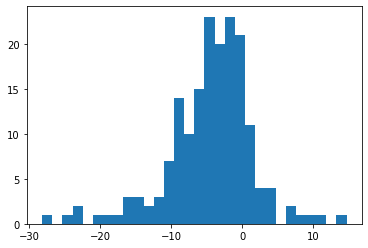

In [14]:
plt.hist(LinearData.slope, bins=30)

In [11]:
print(LinearData.slope.min(),LinearData.slope.max())
print(LinearData.intersect.min(),LinearData.intersect.max())

-28.18257491675915 14.682611731843576
1063.4501144913313 5919.045454545454


In [12]:
for pat in patients:
    train.loc[train['Patient'] == pat, 'slope'] = LinearData.loc[pat, 'slope']
    train.loc[train['Patient'] == pat, 'intersect'] = LinearData.loc[pat, 'intersect']

In [13]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,slope,intersect
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-3.167126,2174.416183
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-3.167126,2174.416183
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-3.167126,2174.416183
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-3.167126,2174.416183
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-3.167126,2174.416183
...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,-1.081317,2919.401434
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,-1.081317,2919.401434
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,-1.081317,2919.401434
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,-1.081317,2919.401434


In [14]:
train['lr_value'] = train.Weeks*train.slope + train.intersect
train['abs_diff'] = np.abs(train.FVC - train.lr_value )

In [15]:
train[train['Patient'] == 'ID00051637202185848464638']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,slope,intersect,lr_value,abs_diff
175,ID00051637202185848464638,-1,1697,81.645417,73,Female,Ex-smoker,-3.37359,1691.838246,1695.211836,1.788164
176,ID00051637202185848464638,1,1569,75.487130,73,Female,Ex-smoker,-3.37359,1691.838246,1688.464655,119.464655
177,ID00051637202185848464638,3,1776,85.446235,73,Female,Ex-smoker,-3.37359,1691.838246,1681.717474,94.282526
178,ID00051637202185848464638,6,1718,82.655761,73,Female,Ex-smoker,-3.37359,1691.838246,1671.596703,46.403297
179,ID00051637202185848464638,7,1682,80.923743,73,Female,Ex-smoker,-3.37359,1691.838246,1668.223112,13.776888
180,ID00051637202185848464638,13,1624,78.133269,73,Female,Ex-smoker,-3.37359,1691.838246,1647.981569,23.981569
181,ID00051637202185848464638,26,1616,77.748376,73,Female,Ex-smoker,-3.37359,1691.838246,1604.124893,11.875107
182,ID00051637202185848464638,37,1520,73.129661,73,Female,Ex-smoker,-3.37359,1691.838246,1567.015398,47.015398
183,ID00051637202185848464638,54,1532,73.707000,73,Female,Ex-smoker,-3.37359,1691.838246,1509.664360,22.335640


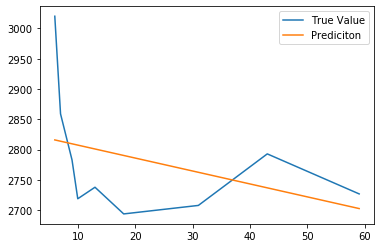

In [34]:
patient = 'ID00419637202311204720264'
plt.plot(train[train['Patient'] == patient].Weeks, train[train['Patient'] == patient].FVC,label='True Value')
plt.plot(train[train['Patient'] == patient].Weeks, train[train['Patient'] == patient].lr_value, label = 'Prediciton')
plt.legend(loc='best')
plt.show()

In [29]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [17]:
len(train[train.abs_diff > 700].Patient.unique())

4

In [18]:
train[train.abs_diff < 70]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,slope,intersect,lr_value,abs_diff
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-3.167126,2174.416183,2158.580554,55.419446
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-3.167126,2174.416183,2145.912050,1.912050
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,-3.167126,2174.416183,2120.575044,19.575044
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,-3.167126,2174.416183,2044.564023,19.435977
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,-3.167126,2174.416183,1993.890009,63.109991
...,...,...,...,...,...,...,...,...,...,...,...
1540,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,-1.081317,2919.401434,2919.401434,5.598566
1541,ID00426637202313170790466,7,2903,71.284746,73,Male,Never smoked,-1.081317,2919.401434,2911.832213,8.832213
1542,ID00426637202313170790466,9,2916,71.603968,73,Male,Never smoked,-1.081317,2919.401434,2909.669579,6.330421
1543,ID00426637202313170790466,11,2976,73.077301,73,Male,Never smoked,-1.081317,2919.401434,2907.506944,68.493056


In [19]:
train.abs_diff.corr(train.Weeks) # little relation with the number of weeks that have passed?

-0.011859100415736996

An important remark is that for a specific value of $\Delta < 1000$ 
the best $\sigma<70$ we can have is given by $\sqrt(2)\Delta$

In [20]:
sigma = train.abs_diff.mean()*np.sqrt(2) # a possible value for sigma
laplace_log_likelihood(train.FVC, train.lr_value, sigma)

-6.077131768171264

In [21]:
sigma = 70*np.sqrt(2)
laplace_log_likelihood(train.FVC, train.lr_value, sigma)

-6.08673691848217

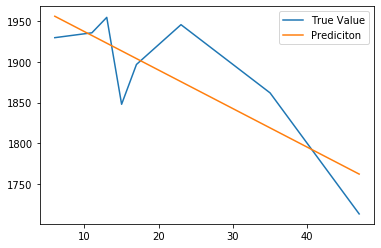

In [22]:
#sorted(train.Weeks,reverse=True)
# 133, 117, 116 - good one, 107 - difficult one, 

patient = 'ID00422637202311677017371'
plt.plot(train[train['Patient'] == patient].Weeks, train[train['Patient'] == patient].FVC,label='True Value')
plt.plot(train[train['Patient'] == patient].Weeks, train[train['Patient'] == patient].lr_value, label = 'Prediciton')
plt.legend(loc='best')
plt.show()

In [23]:
def FVC_line_pred(slope, initial_week, initial_value):
    b = slope*initial_week - initial_value
    def FVC_line(week):
        return slope*week + b
    return FVC_line

FVC_line_pred(10, 5, 2)(1)

58

In [24]:
test2 = test.copy()

In [25]:
test2['slope'] = 0

In [26]:
for n in range(len(test2)):
    test2.loc[n, 'slope'] = train[train.Patient == test2.iloc[n].Patient].slope.tolist()[0]

In [27]:
test2

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,slope
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,-2.135975
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,0.597787
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,-4.740104
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,-9.214886
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,-1.081317


In [28]:
FVC_line_pred(test2.slope, test2.Weeks, test2.FVC)(0)

0   -3032.815850
1   -2730.033194
2   -1958.440626
3   -3450.653056
4   -2925.000000
dtype: float64